<a href="https://colab.research.google.com/github/CPallares96/Emotion_ID/blob/main/Parcial_3_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Detección de emociones primera entrega
#Integrantes: Acuña Roberto, Lagares Juan y Pallares Carlos

In [2]:
import cv2
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import os
from os import listdir
from os.path import isfile, join
import seaborn as sns
from mpl_toolkits import mplot3d
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import preprocessing
%matplotlib inline 

#Imagen de ejemplo de las cuadriculas con la que trabajamos y luego recortamos en sub-cuadriculas de 50x50 pixéles

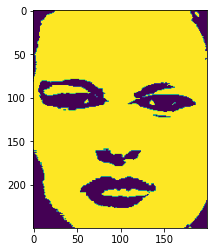

In [3]:
str_dir="/content/drive/MyDrive/Emotion/anger/S074_004_00000010.png"
img = cv2.imread(str_dir)
img = img[130:380, 200:400]
grayImage = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
(thresh, im) = cv2.threshold(grayImage, 127, 255, cv2.THRESH_BINARY)
plt.imshow(im)

#image_set devuelve un dataframe por cada segmento y luego es pegado a un dataframe final en salida_df. En imagen_set si un pixél es negro, se le asigna el valor de 0 sino, el valor de 1. Este bloque de código solo es usado para gráficar una vez en un plano 3D la distribución de los pixéles negros en todas las caras por emoción 

In [4]:
def image_set(im,num):

  df_=pd.DataFrame()
  lista=[]
  listaX=[]
  listaY=[] 

  for y in range(0,250): #Y axis
    for x in range(0,200): #X axis
      if im[y][x] == 255: #[0]==0 and im[y][x][1]==0 and im[y][x][2]==0:
        lista.append(0)
      else:
        lista.append(1)

      listaY.append(y)
      listaX.append(x)

  df_["x"]=np.array(listaX)
  df_["y"]=np.array(listaY)
  df_["type"]=np.array(lista)
  df_["emo"]=np.full(len(df_["x"]),num)
  return df_

def salida_df(dir,arr,num):

  df=pd.DataFrame()
  
  for i in arr:

    str_dir="{}/{}".format(dir,i)
    img = cv2.imread(str_dir)

    #kernel = np.array([[0,1,0], [1,-2,1], [0,1,0]])
    #im = cv2.filter2D(img, -1, kernel)
    #laplacian = cv2.Laplacian(im,cv2.CV_64F)

    grayImage = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    (thresh, im) = cv2.threshold(grayImage, 127, 255, cv2.THRESH_BINARY)
    
    im = im[130:380, 200:400]
    df_= image_set(im,num)
    df=df.append(df_,ignore_index = True)

  return df

#Se "pegan" los tres dataframe correspondientes a cada tipo de imángen (emoción) para un dataframe final que será gráficado mas adelante.

In [5]:
def df_stick(df_1,df_2,df_3):
  df_1=df_1.append(df_2,ignore_index = True)
  df_1=df_1.append(df_3,ignore_index = True)
  return df_1

#Gráfica en 3D de los datos, siendo X el número de pixeles negros, Y el segmento correspondiente y Z la categoría a la que pertenece (1:= Felicidad, 2:=Furia, 3:=Sorpresa)

In [6]:
def df_3Dplot(df):
  x=np.array(df[df.columns[0:1]])
  y=np.array(df[df.columns[1:2]])
  z=np.array(df[df.columns[2:3]])

  fig = plt.figure(figsize = (10, 7))
  ax = plt.axes(projection ="3d")
  
  ax.scatter3D(x, y, z, color = df["emo"])
  plt.title("Emoción")

  plt.show()
  ax.view_init(-45,30)
  fig

#Se aisla solo la nariz, boca y ojos en una cuadricula a partir de la imagen inicial con dimensiones de 250x200 pixéles y se le aplica un filtro monocromatico. Esta funcion devuelve una lista de 20 segmentos por imagen donde cada segmento es de 50x50 pixéles

In [7]:
def segmentacion_cara(img):

  img = img[130:380, 200:400]
  #img = img[130:380, 230:380]

  lista=[]
  alto,ancho,profundidad=img.shape
  cuadro_alto=50
  cuadro_ancho=50
  y=0
  x=0
  cont=0
  for j in range(0,np.divmod(alto,cuadro_alto)[0]):
    y_=(j+1)*cuadro_alto
    for i in range(0,np.divmod(ancho,cuadro_ancho)[0]):
      x_=(i+1)*cuadro_ancho 
      cont=cont+1
      crop_img = img[y:y_, x:x_]

      grayImage = cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)
      (thresh, im) = cv2.threshold(grayImage, 127, 255, cv2.THRESH_BINARY)

      lista.append(im)
      #plt.imshow(im)
      x=x_
    x=0
    y=y_
  return lista

#Se realiza una lectura de todas imagenes por emoción y se devuelve una lista con todos los segmentos de todas las imagenes correspondientes por emoción

In [8]:
def lista_segmentos(str_dir,arr):  
  lista=[]
  for i in (arr):
    dir=str_dir+"/"+i
    img = cv2.imread(dir)
    l=segmentacion_cara(img)
    lista.extend(l)
  return lista

#Se realiza el conteo de los pixéles negro por segmento de cada imagen para todas las imagenes de una emoción, el valor de parametro "lista" es obtenido de la función anterior "lista_segmentos" y se devuelve un dataframe con tres columnas: X el número de pixeles negros, Y el segmento correspondiente, Z la categoría a la que pertenece (1:= Felicidad, 2:=Furia, 3:=Sorpresa) y emo el color asignado a la emoción, verde:=Felicidad, rojo:=Furia, azul:= Sorpresa

In [9]:
def n_black_per_segment(lista,string,num):
  df=pd.DataFrame()
  cont=0
  n_segmento=[]
  num_black=[]
  emo=[]
  num_z=[]
  for i in range(0,len(lista)):
    cont=cont+1
    n_segmento.append(cont)
    emo.append(string)
    num_z.append(num)
    num_black.append(np.count_nonzero(lista[i] == 255))
    if  20-cont == 0: #15-cont cuando img = img[130:380, 230:380] en segmentacion_cara
      cont=0
  df["x"]=num_black
  df["y"]=n_segmento
  df["z"]=num_z
  df["emo"]=emo
  return df

#Menú básico para selección de las categorías de imágenes que queremos utilizar para nuestro análisis.

In [10]:
def seleccion_n_datos(categoria,str_dir):
  arr=os.listdir(str_dir)
  lista=[]
  string="¿Desea incluir la categoría {} en siguiente analisis? Digitar en miniscula su respuseta (si/no)".format(categoria)
  print(string)
  opcion = input()
  if opcion == "no":
    lista.append(arr[0])
  else:
    lista.extend(arr)
  return lista

#Montando los datos. Los datos son motandos desde mi Drive, por lo cual si se quiere cambiar la dirección de los datos, debe cambiarse la variable str_dir en los tres casos siguientes. No modificar ningún parametro de entrada en la definición de arr para los tres casos (emociones).

In [11]:
str_dir="/content/drive/MyDrive/Emotion/happiness"
arr = seleccion_n_datos("happiness",str_dir)
lista_1=lista_segmentos(str_dir,arr)
df_1=salida_df(str_dir,arr,"green")

str_dir="/content/drive/MyDrive/Emotion/anger"
arr = seleccion_n_datos("anger",str_dir)
lista_2=lista_segmentos(str_dir,arr)
df_2=salida_df(str_dir,arr,"red")

str_dir="/content/drive/MyDrive/Emotion/surprise"
arr = seleccion_n_datos("surprise",str_dir)
lista_3=lista_segmentos(str_dir,arr)
df_3=salida_df(str_dir,arr,"blue")

¿Desea incluir la categoría happiness en siguiente analisis? Digitar en miniscula su respuseta (si/no)
si
¿Desea incluir la categoría anger en siguiente analisis? Digitar en miniscula su respuseta (si/no)
si
¿Desea incluir la categoría surprise en siguiente analisis? Digitar en miniscula su respuseta (si/no)
si


#DF DE SEGMENTOS Y NUMERO DE PIXELES NEGROS POR CADA UNO

In [12]:
df1=n_black_per_segment(lista_1,"green",1)
df2=n_black_per_segment(lista_2,"red",2)
df3=n_black_per_segment(lista_3,"blue",3)
dF=df_stick(df1,df2,df3)

#GRÁFICA DE LAS IMAGENES EN UN ESPACIO 3D

#Todas las imagenes han sido puestas en esta gráfica. El eje Z indica la categoría, 1 para pixéles negrs y 0 para pixéles blancos (amarillosos en nuestro caso). El color verde es Felicidad, el rojo es Furia y el azul es Sorpresa. Basandonos en los colores vemos existen gaps entre las emociones que son llenados por otras, un ejemplo es el centro de la categoría 1 que muestra como la Furia(rojo) llena un vacio que existe en las imagenes de Sorpresa(azul)

In [ ]:
df_3Dplot(df_stick(df_1,df_2,df_3))

#Gráfica emoción Felicidad

In [ ]:
df_3Dplot(df_1)

#Gráfica emoción Furia

In [ ]:
df_3Dplot(df_2)

#Gráfica emoción Sorpresa

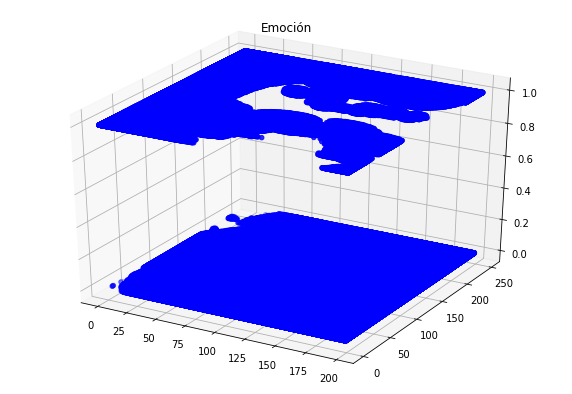

In [ ]:
df_3Dplot(df_3)

#OMITIR LOS DOS SIGUIENTES BLOQUES DE CÓDIGO Y RETOMAR EN EL CLUSTERING

#KMEANS - Clustering. Realizamos agrupación de los datos y vemos si realmente se separan de forma natural

In [ ]:
inertia = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(dF[dF.columns[0:3]])
    inertia.append(kmeanModel.inertia_)

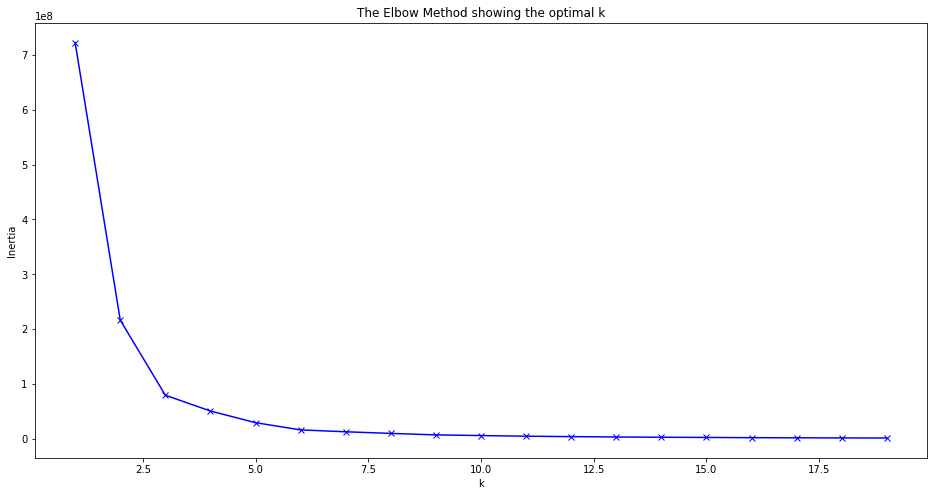

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal k')
plt.show()

#Respecto al método del codo tomamos que la mejor cantidad de clusters son 3

In [ ]:
kmeanModel = KMeans(n_clusters=3)
kmeanModel.fit(dF[dF.columns[0:3]])
dF["tag"]=pd.Series(kmeanModel.labels_)

In [ ]:
def df3Dplot(df):
  x=np.array(df[df.columns[0:1]])
  y=np.array(df[df.columns[1:2]])
  z=np.array(df[df.columns[4:5]])

  fig = plt.figure(figsize = (10, 7))
  ax = plt.axes(projection ="3d")
  
  ax.scatter3D(x, y, z, color = df["emo"])
  plt.title("Emoción")

  plt.show()
  ax.view_init(80,90)
  fig

In [ ]:
df3Dplot(dF)

In [ ]:
sns.scatterplot(data=dF,x="x",y="y",hue="z",palette="deep",alpha=0.60)
plt.title("Separación sincon KMeans") #title
plt.ylabel("Número de la sub-cuadricula") #x label
plt.xlabel("Pixéles por sub-cuadricula") #y label

# Visualizamos una separación de los datos cuando K=3 d, donde los datos que se encontraban mezclados anteriormente ahora están separados en clusters diferentes, pero los puntos siguen en su mismas posiciones, esto da a entender que los puntos ahora separados son propios de ciertas emociones y le dan caracteristicas únicas a estas mismas.

#Para este caso 0:=Felicidad, 1:=Furia y 2:=Sorpresa

In [ ]:
sns.scatterplot(data=dF,x="x",y="y",hue="tag")
plt.title("Separación con KMeans") #title
plt.ylabel("Número de la sub-cuadricula") #x label
plt.xlabel("Pixéles por sub-cuadricula") #y label

#CLUSTERING

#La siguiente función toma cada imagen de cada emociones como y las registra de la siguiente forma en el dataframe:

                   index      0         1     ...    20

                    0       2156       865           1
                    1       701        1597          1
                    2       51         616           1
                    .        .          .            .
                    .        .          .            .
                    .        .          .            .
                    45      759        767           1
                    46      1679       12            1
    
#La columna del 0 al 19 corresponden a los 20 segmentos de cada y contienen el número de pixéles negros por segmentos correspondiente. La columna 20 se refiere al tipo de imagen o emoción a la que corresponden esos segmentos. 

In [13]:
def full_DataF(lista,num):
  cont=0
  lista_=[]
  for i in range(0,len(lista)):
    if np.divide(i+1,20).is_integer():
      lista_.append(np.count_nonzero(lista[i] == 255))
      lista_.append(num)
      if cont==0:
        cont=1
        df=pd.DataFrame([lista_])
      else:
        a_series=pd.Series(lista_,index=df.columns)
        df=df.append(a_series,ignore_index=True)
      lista_.clear()
    else:
      lista_.append(np.count_nonzero(lista[i] == 255))
    
  return df

#Se unen los dataframe correspondientes a Felicidad, Furia y Sorpresa con la función df_stick anteriormente mencionada.

In [14]:
dF_1=full_DataF(lista_1,1)
dF_2=full_DataF(lista_2,2)
dF_3=full_DataF(lista_3,3)
dF_f=df_stick(dF_1,dF_2,dF_3)

#Normalización de los datos - La varianza explicada por cada componente es menor si los datos son normalizados.

In [15]:
x = dF_f.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
dF_f = pd.DataFrame(x_scaled)

#Ground thrut, son los valores reales de mis datos los cuales son comparados luego de realizar fit's en metodos de clustering y reducción de imagenes

In [16]:
ground_truth = dF_f[[20]].values
lookupTable, ground_truth = np.unique(ground_truth, return_inverse=True)
X = dF_f[dF_f.columns[0:20]].values

In [18]:
from sklearn.cluster import AgglomerativeClustering
agrupamiento = AgglomerativeClustering(n_clusters=3,
                                     distance_threshold=None,
                                     compute_full_tree=True,
                                     affinity='euclidean',
                                     linkage='complete').fit(X)
predicho = agrupamiento.labels_
from sklearn import metrics
# adjusted_rand_score entre -1 y 1, mayor que cero es bueno, 1 es perfecto
print(metrics.adjusted_rand_score(ground_truth, predicho))
# adjusted_mutual_info_score 0 y 1, 1 es perfecto
print(metrics.adjusted_mutual_info_score(ground_truth, predicho))
from sklearn.metrics.cluster import contingency_matrix
cm =contingency_matrix(ground_truth, predicho, eps=None, sparse=False)
pd.DataFrame(cm)

-0.0019218777770079443
0.05564040083450314


,0,1,2
0,18,16,12
1,12,0,3
2,9,7,8


In [19]:
agrupamiento = KMeans(n_clusters=3).fit(X)
predicho = agrupamiento.labels_
from sklearn import metrics
# adjusted_rand_score entre -1 y 1, mayor que cero es bueno, 1 es perfecto
print(metrics.adjusted_rand_score(ground_truth, predicho))
# adjusted_mutual_info_score 0 y 1, 1 es perfecto
print(metrics.adjusted_mutual_info_score(ground_truth, predicho))
from sklearn.metrics.cluster import contingency_matrix
cm =contingency_matrix(ground_truth, predicho, eps=None, sparse=False)
pd.DataFrame(cm)

-0.0019218777770079443
0.05564040083450314


,0,1,2
0,18,16,12
1,12,0,3
2,9,7,8


In [20]:
from sklearn.cluster import AffinityPropagation
agrupamiento = AffinityPropagation(preference=-5.0, damping=0.9,max_iter=10000).fit(X)
predicho = agrupamiento.labels_
from sklearn import metrics
# adjusted_rand_score entre -1 y 1, mayor que cero es bueno, 1 es perfecto
print(metrics.adjusted_rand_score(ground_truth, predicho))
# adjusted_mutual_info_score 0 y 1, 1 es perfecto
print(metrics.adjusted_mutual_info_score(ground_truth, predicho))
from sklearn.metrics.cluster import contingency_matrix
cm =contingency_matrix(ground_truth, predicho, eps=None, sparse=False)
pd.DataFrame(cm)



0.3564383782607302
0.5944809316346916


,0,1,2,3,4,5,6,7
0,12,18,16,0,0,0,0,0
1,0,2,0,10,3,0,0,0
2,0,0,0,0,0,8,7,9


In [21]:
from sklearn.cluster import DBSCAN
agrupamiento = DBSCAN(eps=0.3,min_samples=50,metric="euclidean").fit(X)
predicho = agrupamiento.labels_
from sklearn import metrics
# adjusted_rand_score entre -1 y 1, mayor que cero es bueno, 1 es perfecto
print(metrics.adjusted_rand_score(ground_truth, predicho))
# adjusted_mutual_info_score 0 y 1, 1 es perfecto
print(metrics.adjusted_mutual_info_score(ground_truth, predicho))
from sklearn.metrics.cluster import contingency_matrix
cm =contingency_matrix(ground_truth, predicho, eps=None, sparse=False)
pd.DataFrame(cm)

0.0
6.494925741535911e-16


,0
0,46
1,15
2,24


#Ground truth y PCA. Se toman los valores de cada categoría en ground_truth para luego retomarlos cuando PCA arroje los datos transformados y ver si existen categorias que no se superponen.

#X son todos los valores del dataframe excluyendo su última columna que corresponde a la emoción que pertenece cada imágen

#Se define PCA con n_components=2 para visualizar en 2D. Código obtenido del curso IA dictado por el profesor Eduardo Zurek en el periodo 2021-01.

[0.4451507 0.2044214]
[8.98484542 6.08863946]
(85, 2)


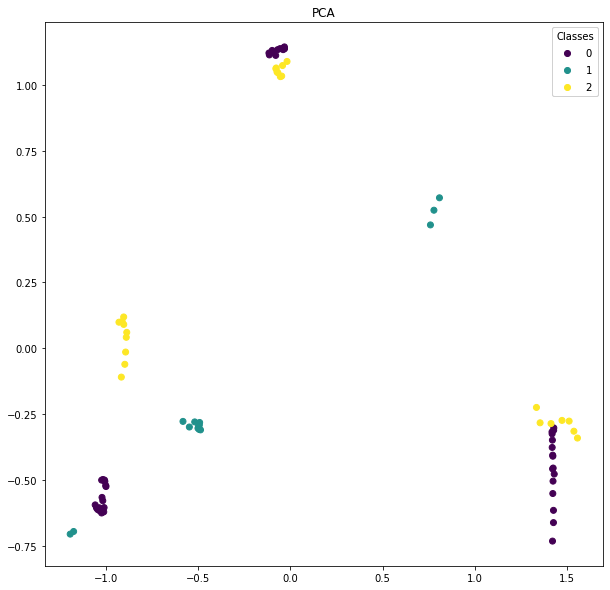

In [31]:
pca = PCA(n_components=2,whiten=False).fit(X)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
transformados = pca.fit_transform(X)
print(transformados.shape)

x = transformados[:,0]
y = transformados[:,1]
c = ground_truth
fig, ax = plt.subplots(figsize=[10,10])

scatter = ax.scatter(x, y, c=c,alpha=1.0)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)
plt.title("PCA") #title
plt.show()

#MDS

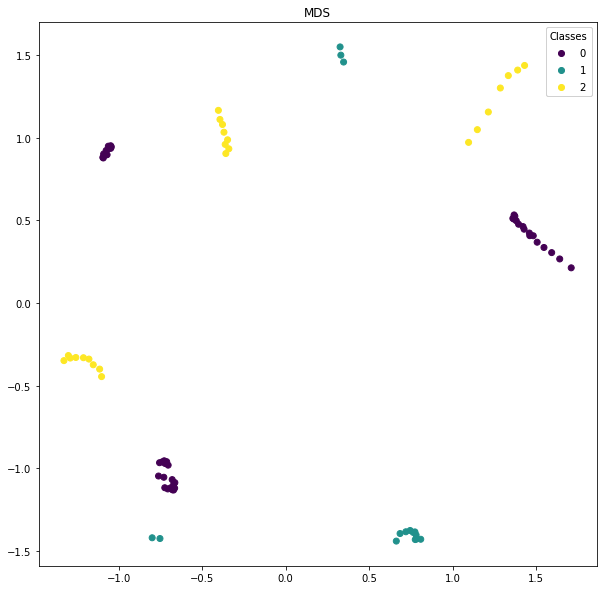

In [33]:
embedding = MDS(n_components=2)
transformados = embedding.fit_transform(X)

x = transformados[:,0]
y = transformados[:,1]
c = ground_truth
fig, ax = plt.subplots(figsize=[10,10])

scatter = ax.scatter(x, y, c=c,alpha=1.0)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)
#print(pca.explained_variance_ratio_)
#print(pca.singular_values_)
plt.title("MDS") #title
plt.show()

PC1*a+PC2*b

# La clase 0 corresponde a la clase Felicidad, la clase 1 a la clase Furia y la clase 2 a la clase Sorpresa.

#Se osbserva una separación de las categorías (emociones) y los datos no están superpuesto por lo cual las componenetes 1 y 2 son suficientes. Al estar los datos superpuestos es como si la funcion lineal el terminos de PC1 y PC2 (PC_1 * a + PC_2 * B)  dieran igual para ambas categorias (triste y sorprendido)

#KNN - Aprendizaje supervisado, aplicación. Predicción de emociones (se obtienen mejores resultados cuando solo se comparan dos emociones). La salida ejemplo de este bloque de código es:
                   precision    recall  f1-score   support

           1       0.77      0.93      0.85       275
           2       0.00      0.00      0.00         7
           3       0.78      0.51      0.61       144

#Siendo 1:= Felicidad, 2:=Furia y 3:=Sorpresa. Para este caso solo testeamos con 2 emociones, solo nos quedamos con un dato de la emoción 2 para evitar errores de lógica en nuestro código, por esta misma razón la precisión es del 0.0%

In [ ]:
np.random.seed(0)

dF_=dF_f.sample(frac=1)

x=np.array(dF_[dF_.columns[0:20]])
y=np.array(dF_[dF_.columns[20:21]])
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.30)

neigh = KNeighborsClassifier(n_neighbors=25,weights="distance")
neigh.fit(x_train, y_train)

y_pred=neigh.predict(x_test)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         7

    accuracy                           1.00        26
   macro avg       1.00      1.00      1.00        26
weighted avg       1.00      1.00      1.00        26

[[13  0  0]
 [ 0  6  0]
 [ 0  0  7]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
